In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
torch.cuda.set_device(device)

In [4]:
from utils import load_cifar10, load_cifar100, load_tinyimagenet

In [5]:
# load cifar10 data
trainloader, testloader = load_cifar10(data_dir="../data/cifar10", batch_size=128, 
                                       test_batch = 128,train_shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# load dataloader for steal
stealloader,_ = load_cifar100(data_dir="../data/cifar100", batch_size=128, train_shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# load tinyimagenet for outlier exposure
outlier_loader = load_tinyimagenet(data_dir="../data/tiny-imagenet-200",
                                   batch_size=128, train_shuffle=True)

# Steal Model 

## Attack comb net

- CombNet 에서 tau 설정 필요
- nb_stolen 으로 steal 시에 사용할 데이터 수 정할 수 있음

In [8]:
class args:
    save_dir = "../results"
    orig_model = "net_taylor.pth"
#     fake_model = "cifar_fake_random_net.pth"
    fake_model = "cifar_fake_taylor_swae.pth"
    tau = 0.5
    nb_stolen = 50000 # attack model 학습시 사용할 데이터 수
    att_epochs = 50
    att_model = str(tau)+"_cifar_att_net.pth"

In [9]:
from cifar_models import Net_prev, Net_logit_prev, AttackNet_prev
from utils import CombNet, CombNet_soft

In [10]:
import os
net = Net_prev()
net.load_state_dict(torch.load(os.path.join(args.save_dir,args.orig_model),map_location='cpu'))
net_fake = Net_prev()
net_fake.load_state_dict(torch.load(os.path.join(args.save_dir,args.fake_model),map_location='cpu'))
comb_net = CombNet_soft(net, net_fake, tau=args.tau)

In [11]:
aa = next(iter(testloader))
bb = next(iter(trainloader))

In [12]:
from utils import plot_individual_prediction

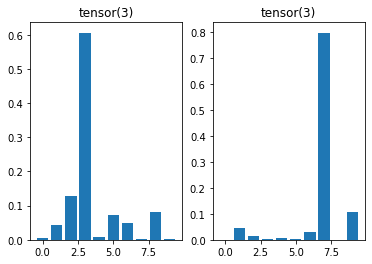

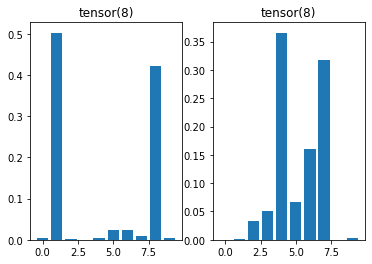

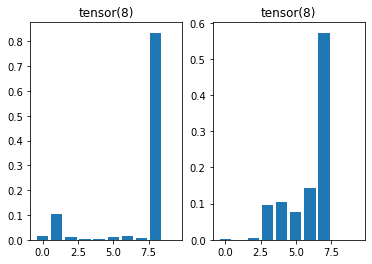

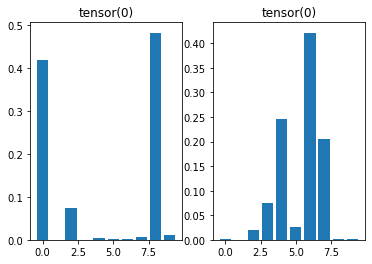

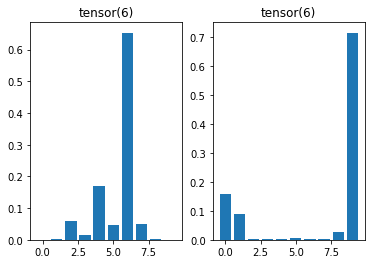

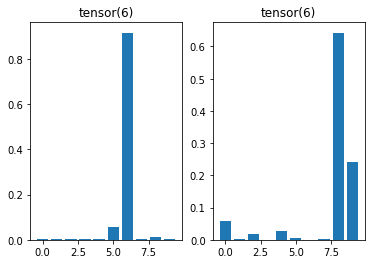

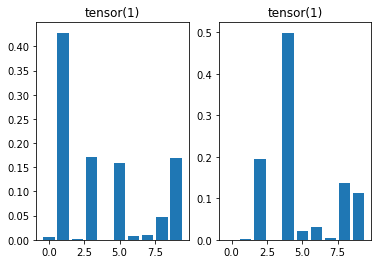

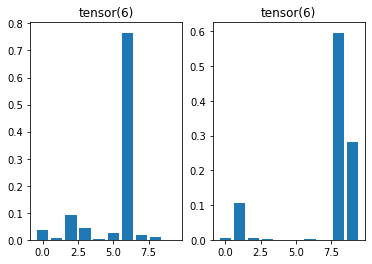

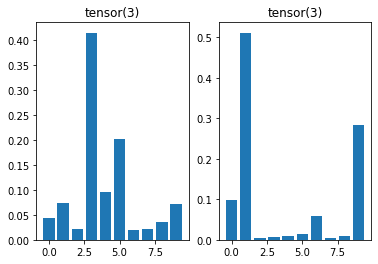

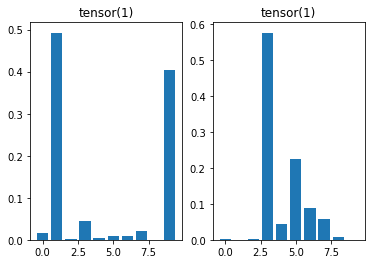

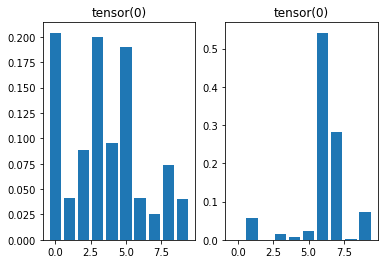

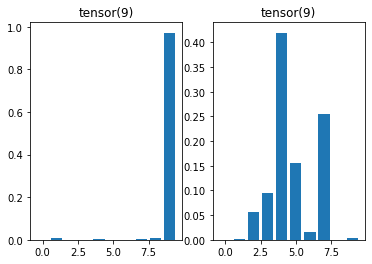

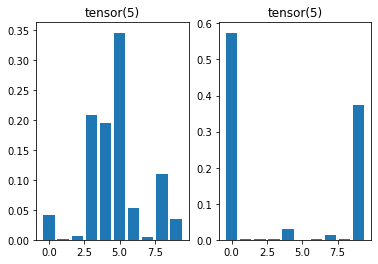

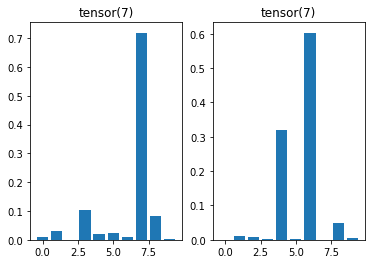

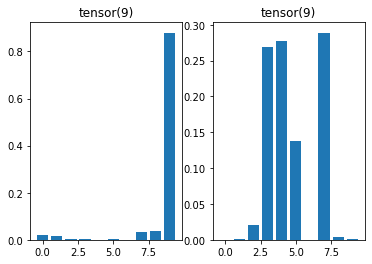

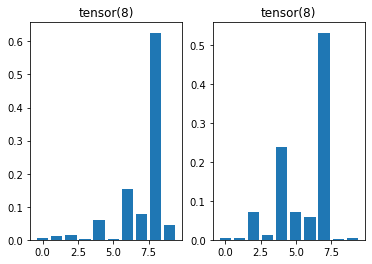

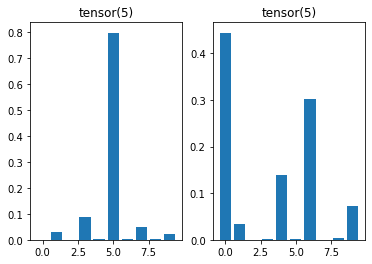

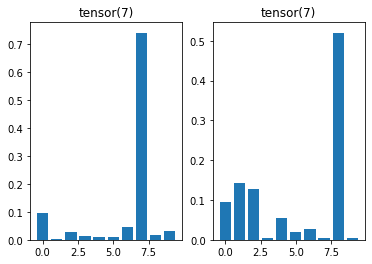

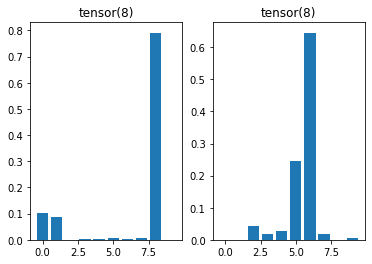

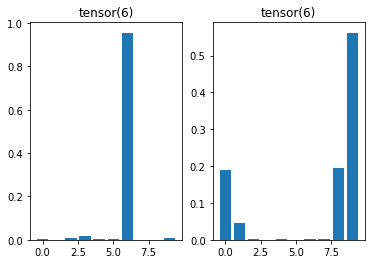

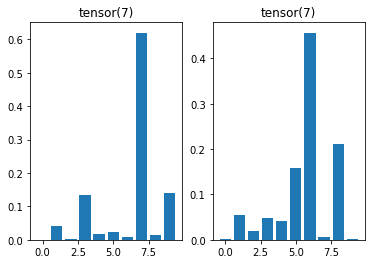

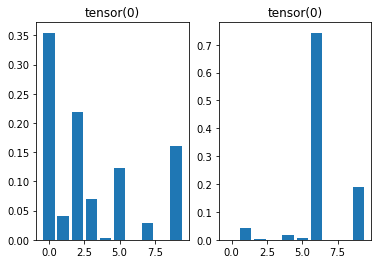

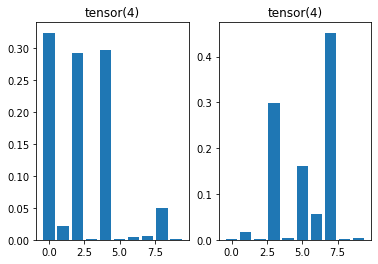

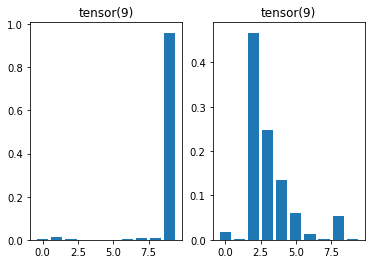

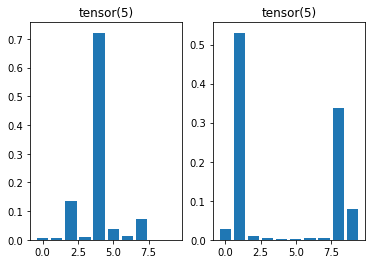

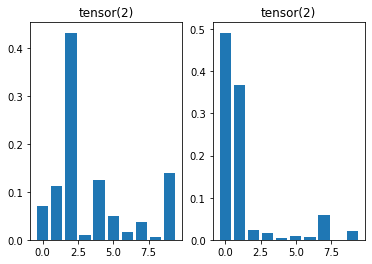

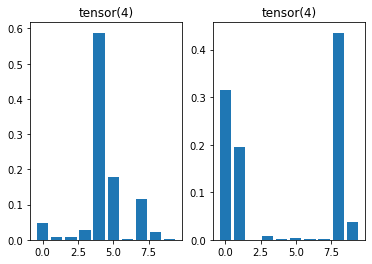

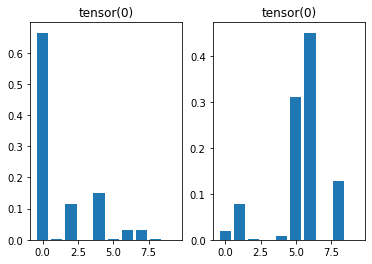

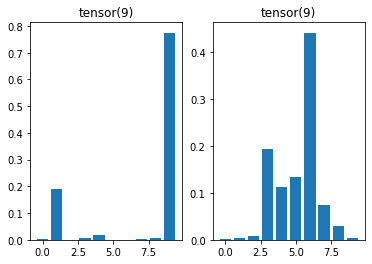

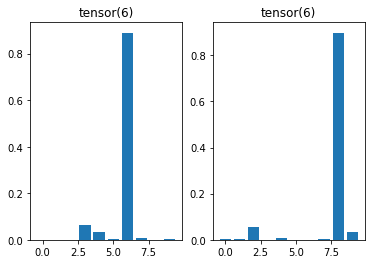

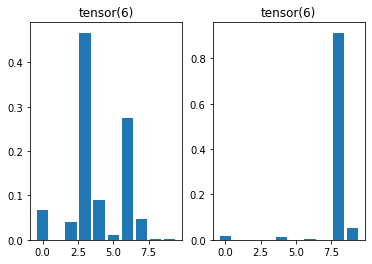

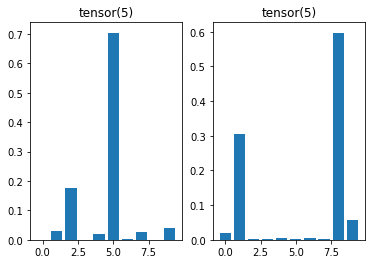

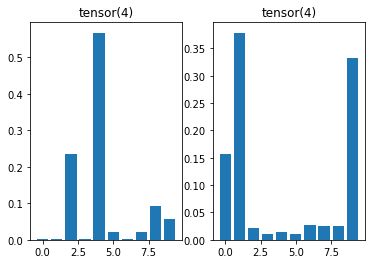

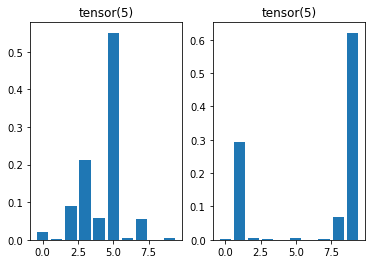

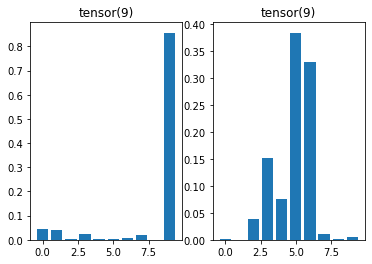

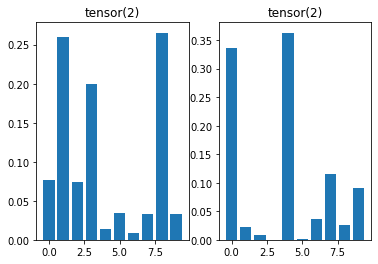

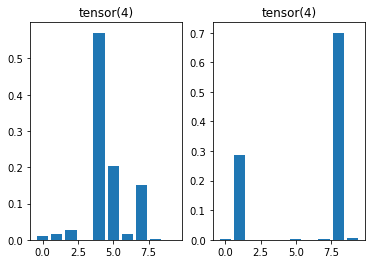

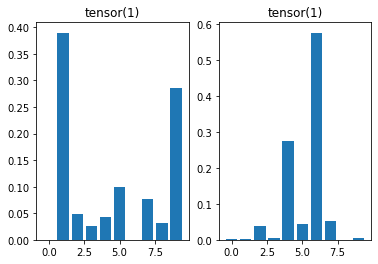

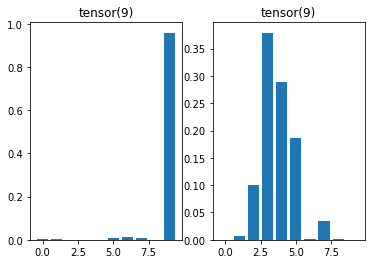

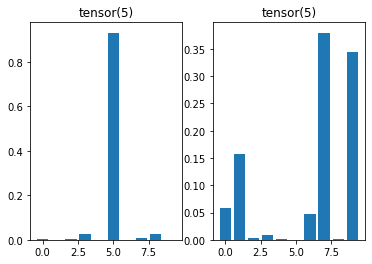

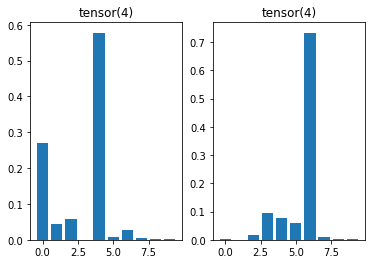

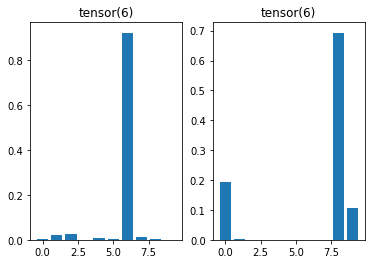

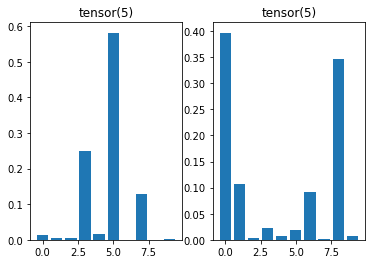

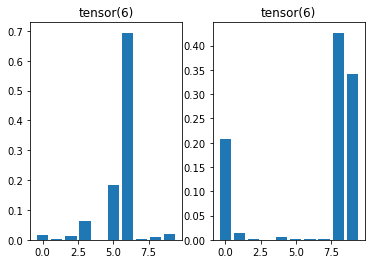

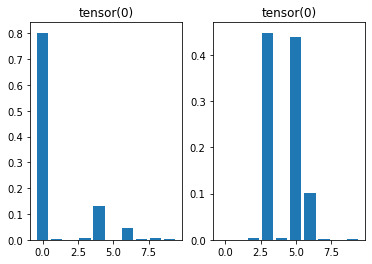

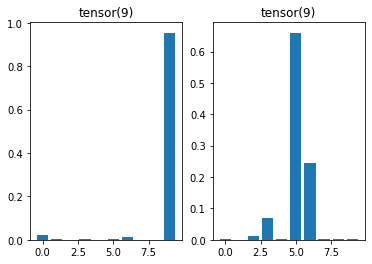

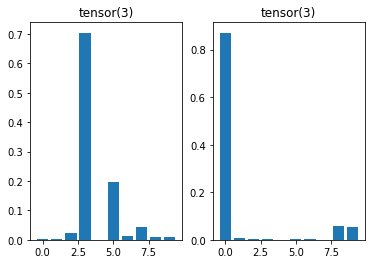

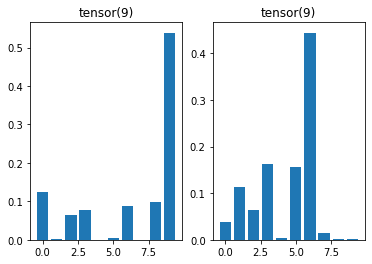

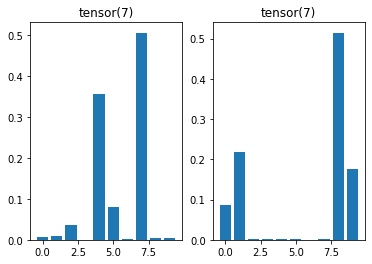

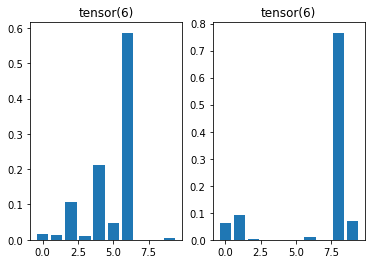

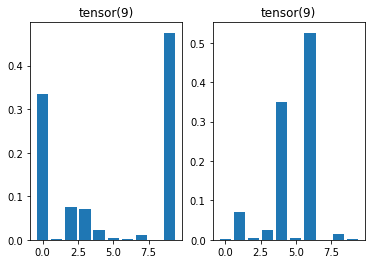

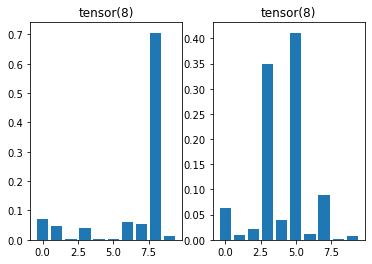

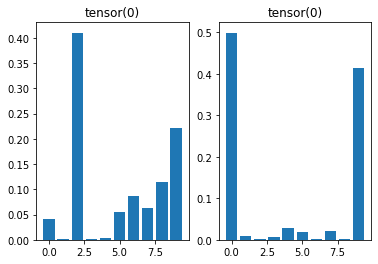

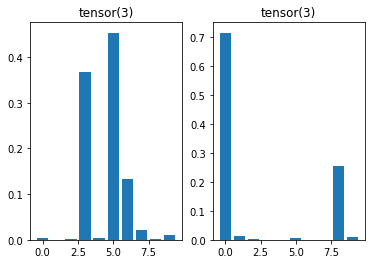

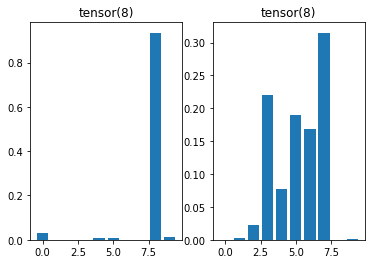

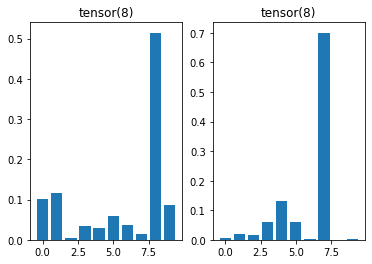

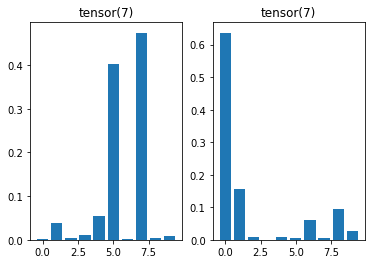

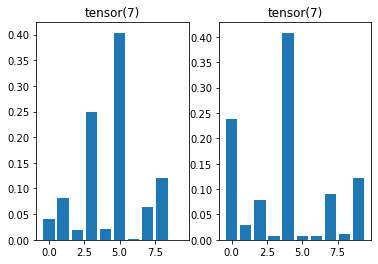

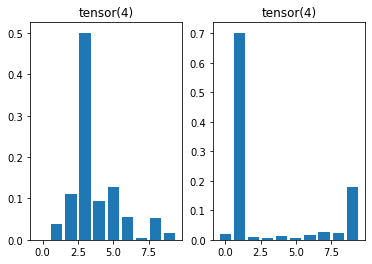

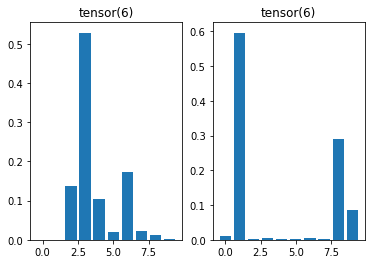

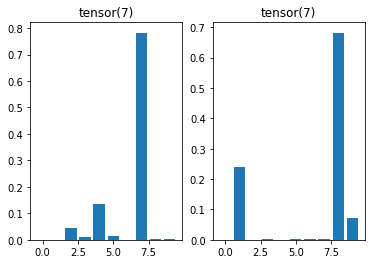

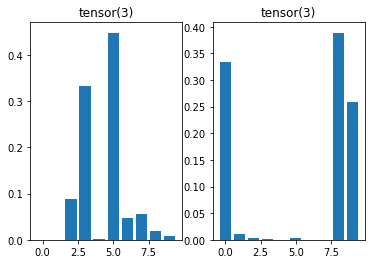

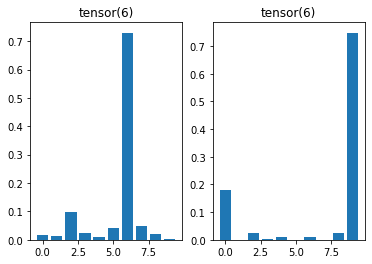

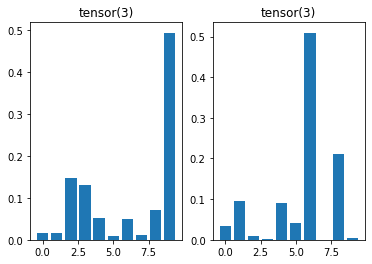

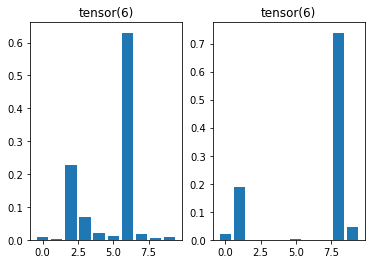

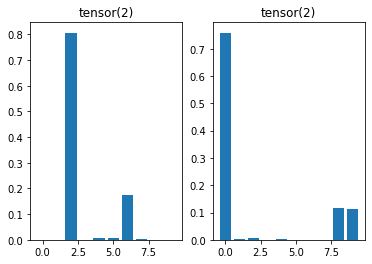

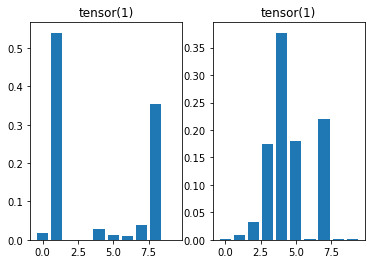

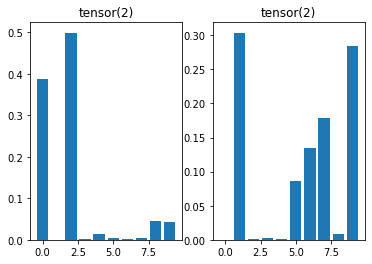

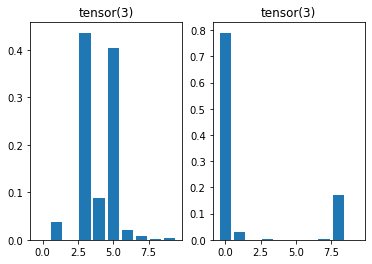

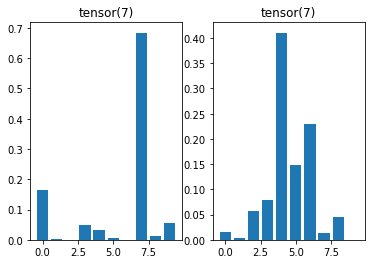

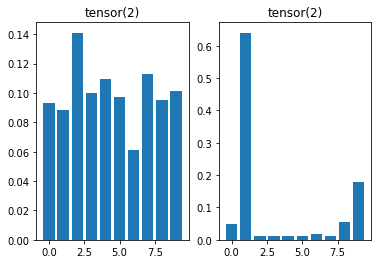

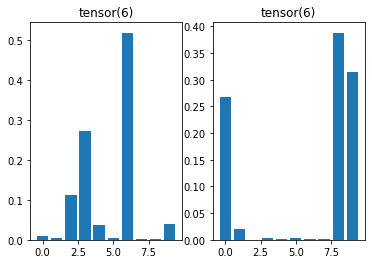

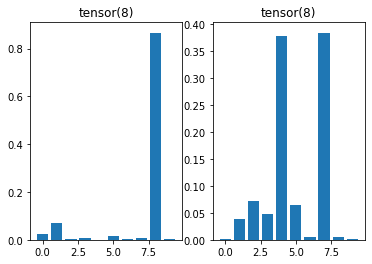

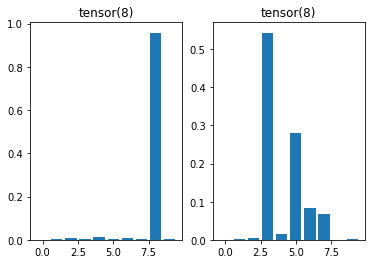

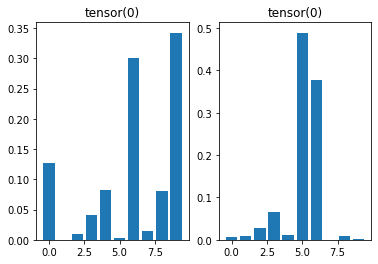

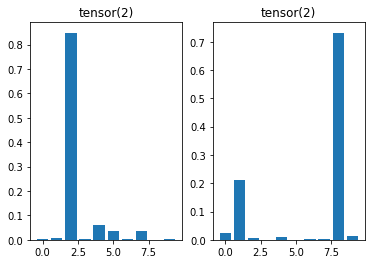

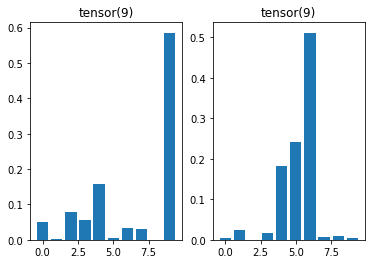

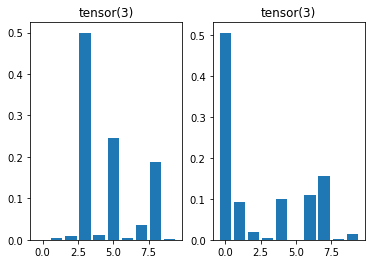

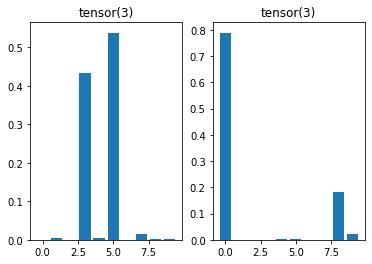

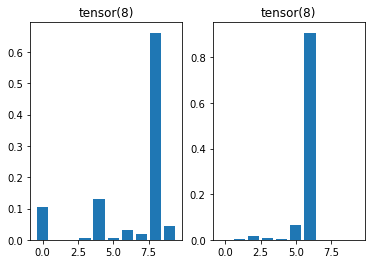

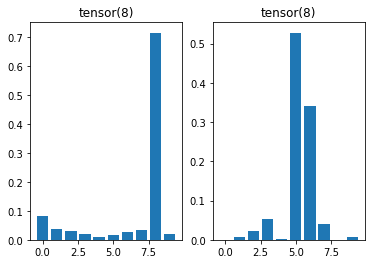

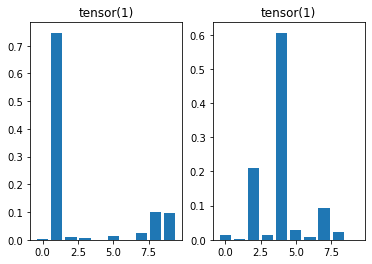

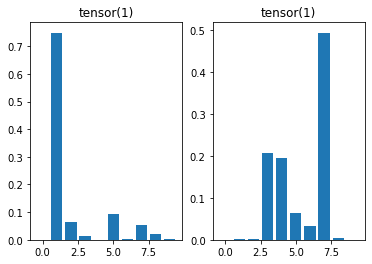

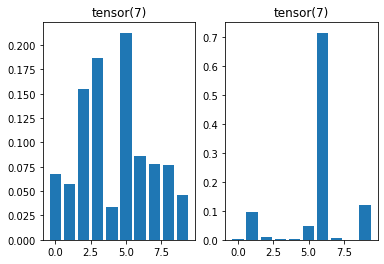

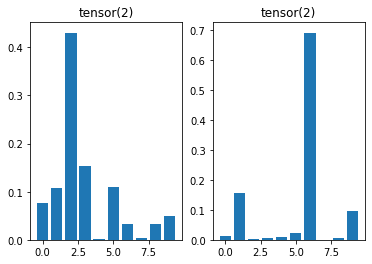

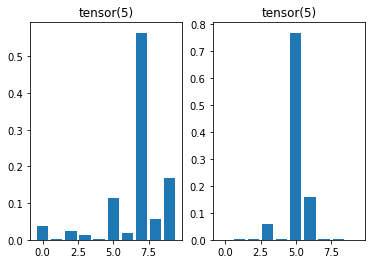

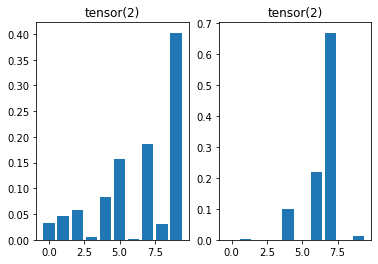

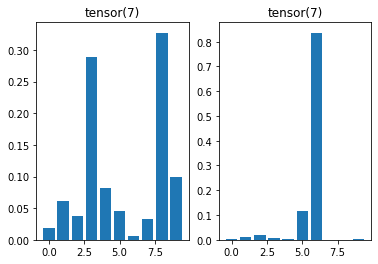

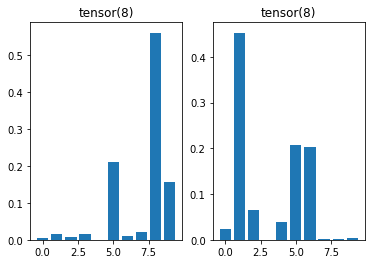

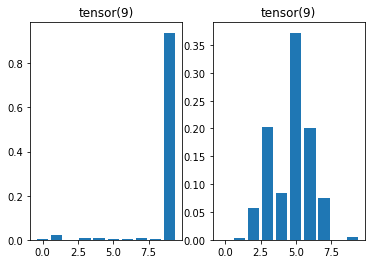

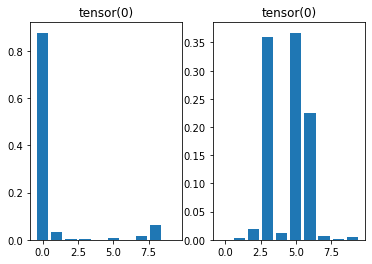

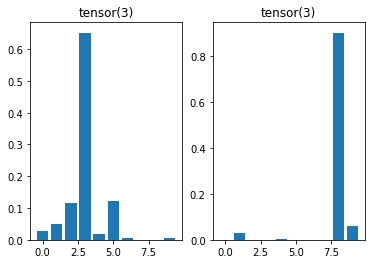

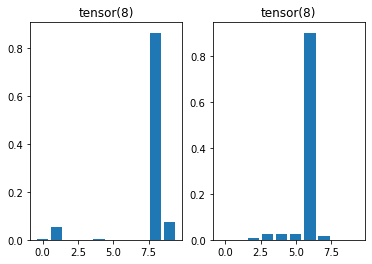

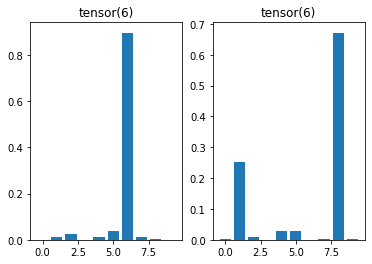

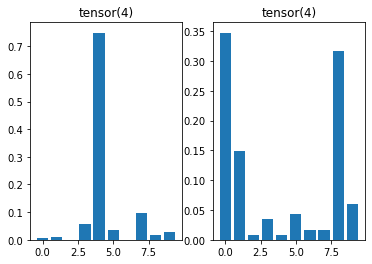

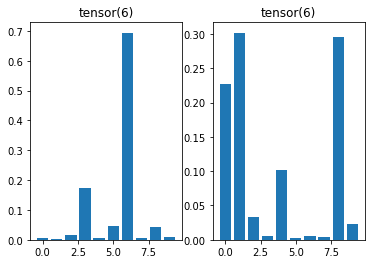

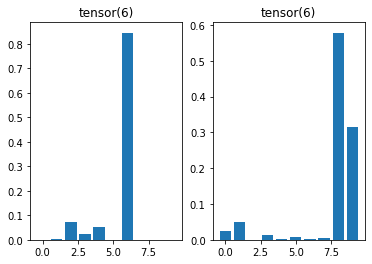

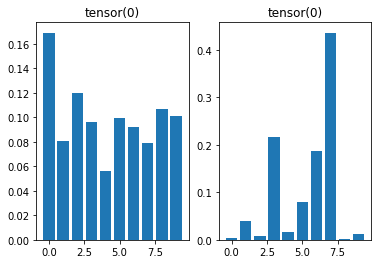

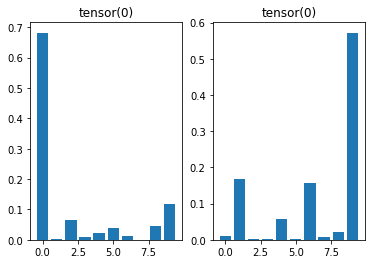

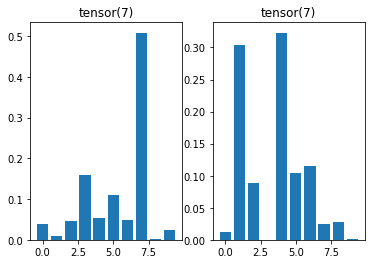

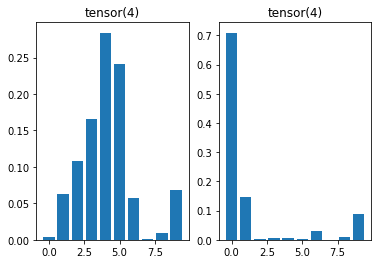

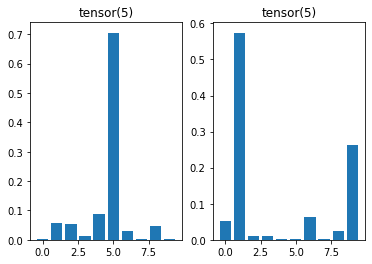

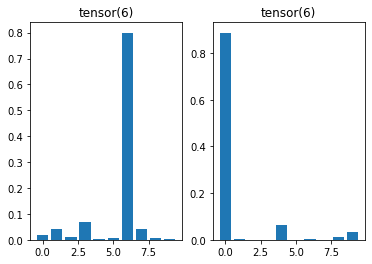

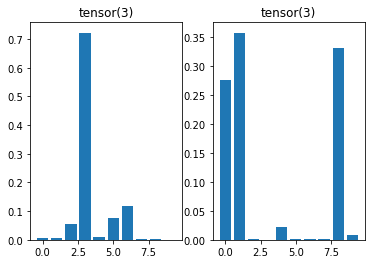

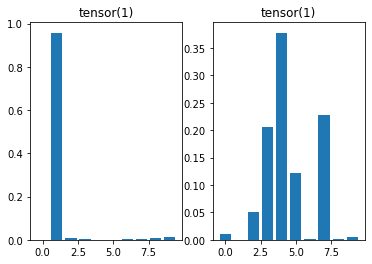

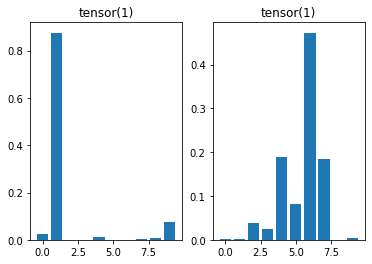

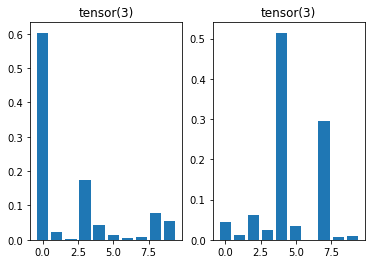

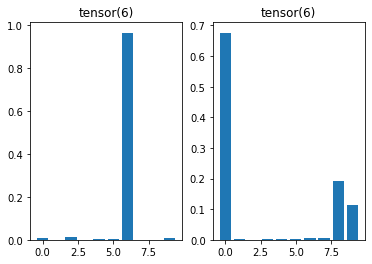

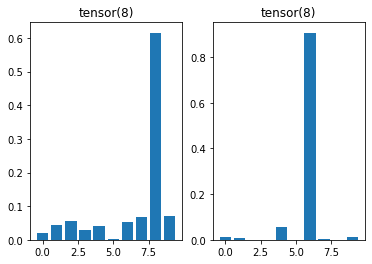

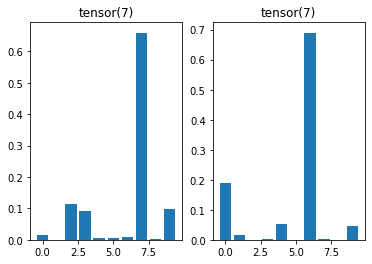

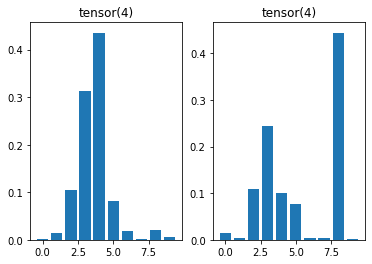

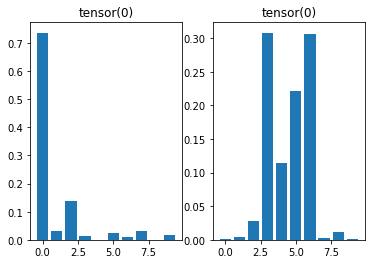

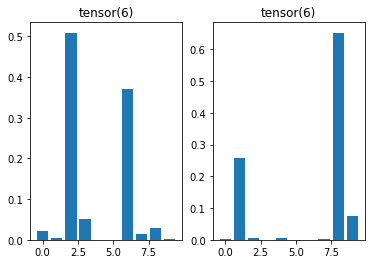

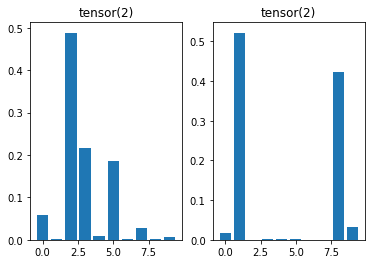

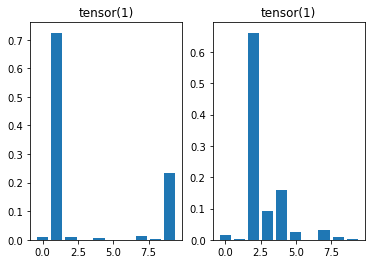

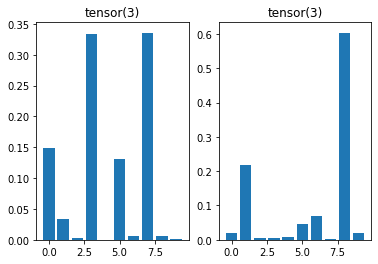

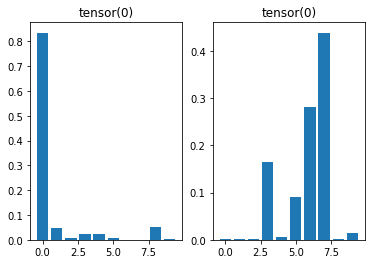

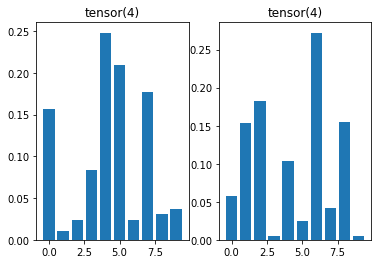

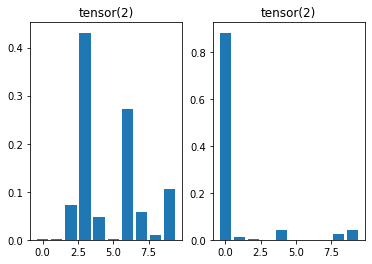

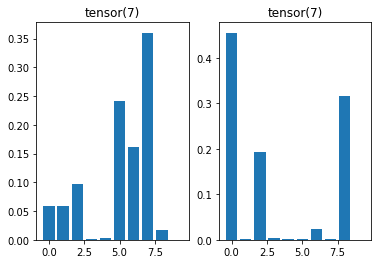

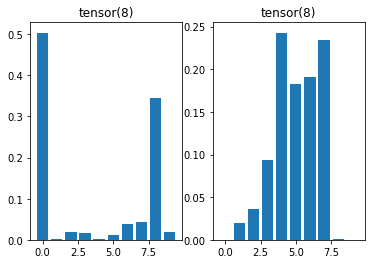

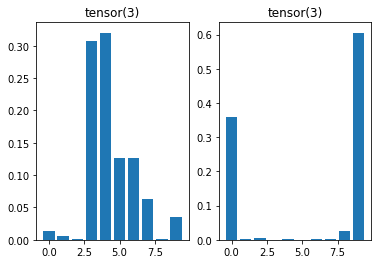

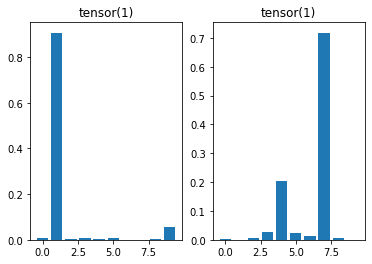

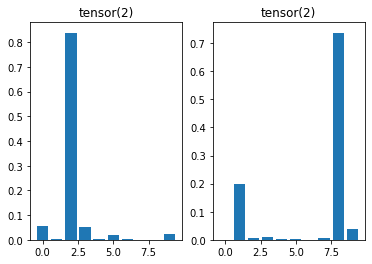

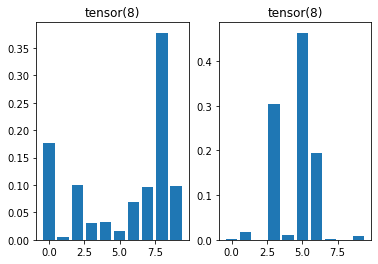

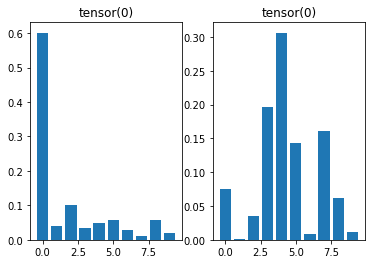

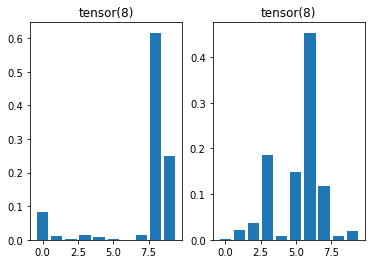

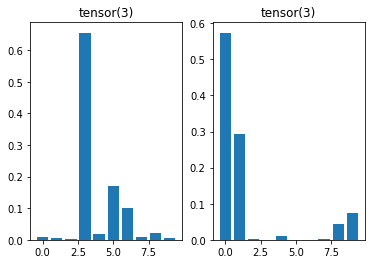

In [14]:
plot_individual_prediction(aa[0], aa[1], device, net, net_fake) 

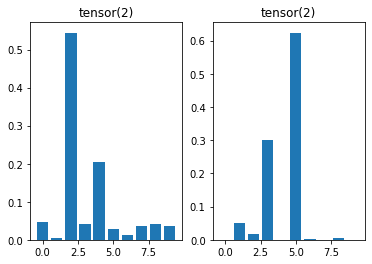

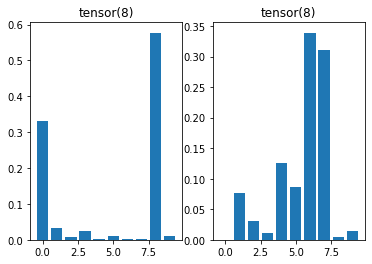

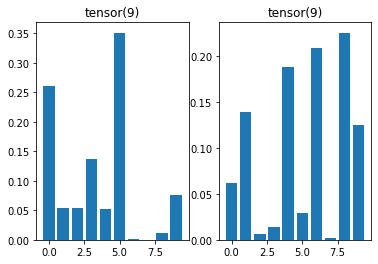

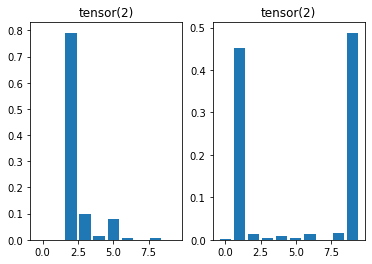

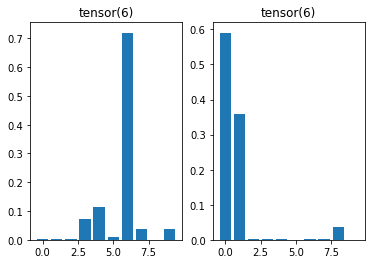

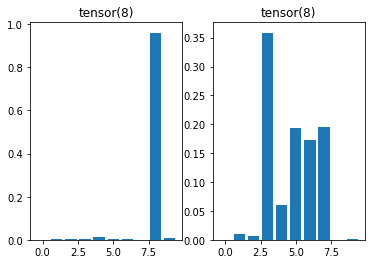

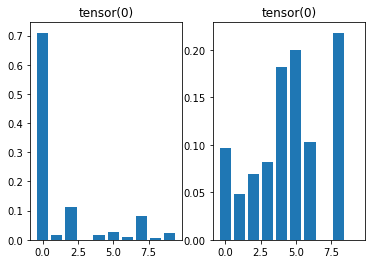

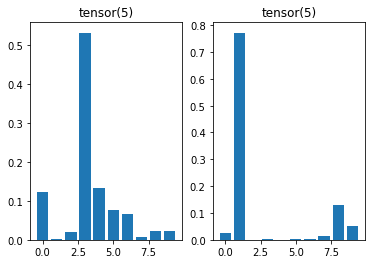

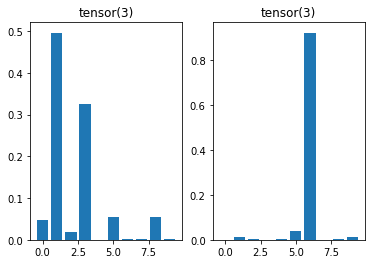

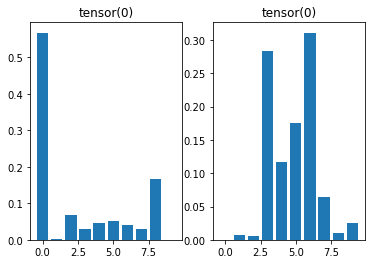

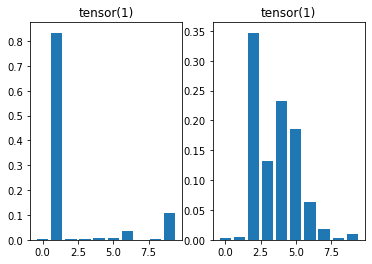

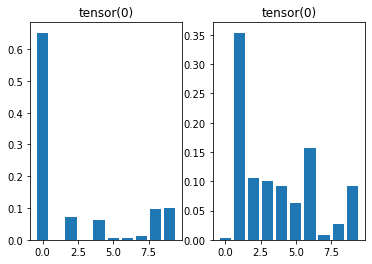

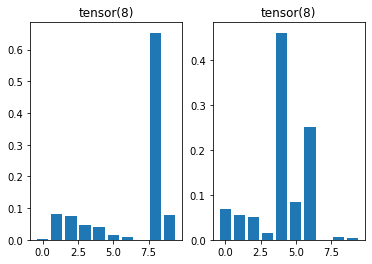

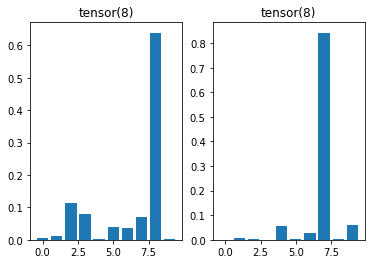

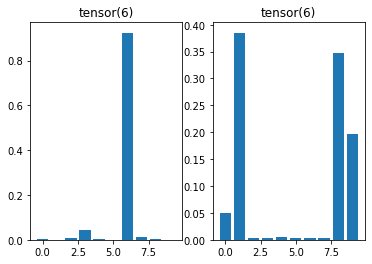

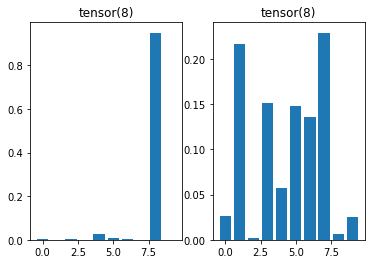

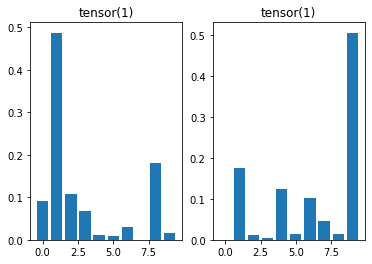

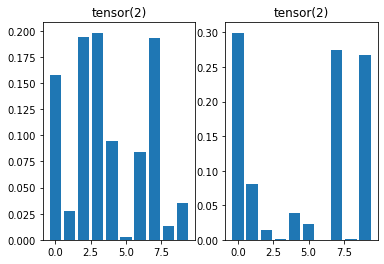

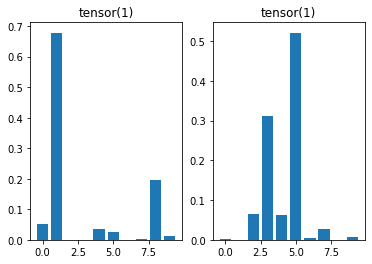

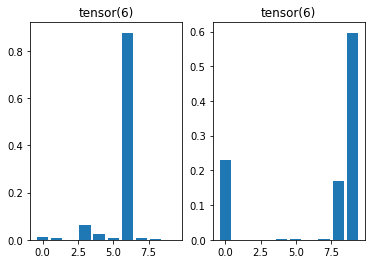

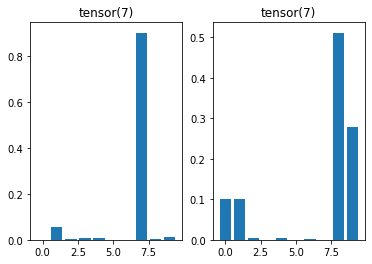

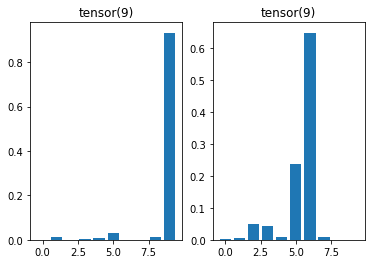

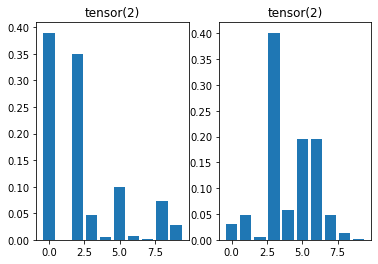

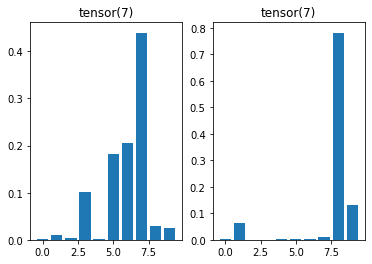

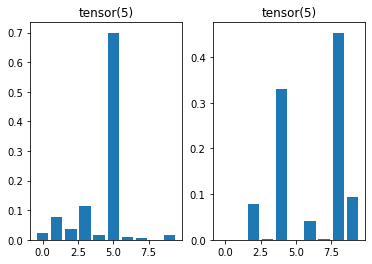

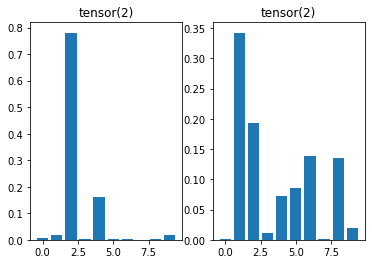

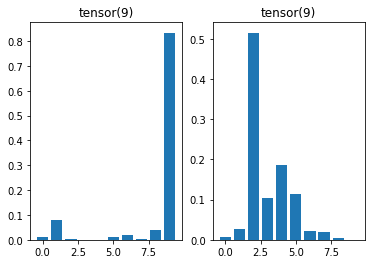

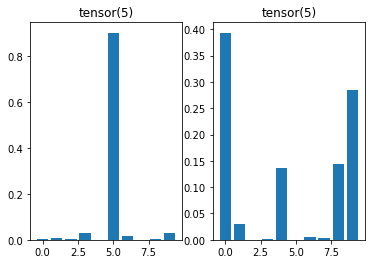

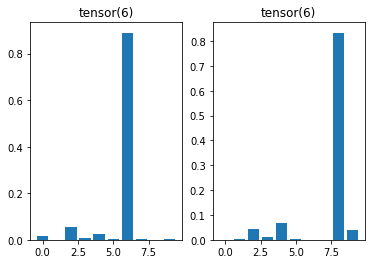

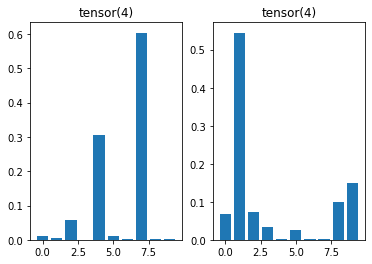

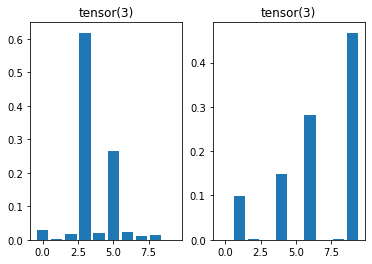

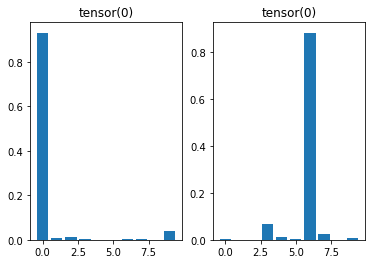

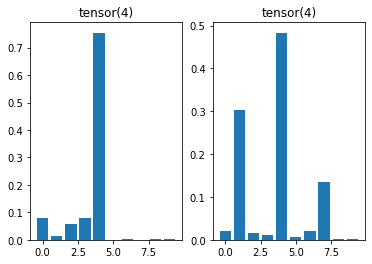

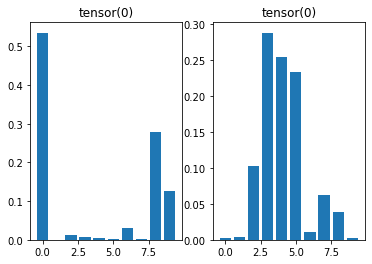

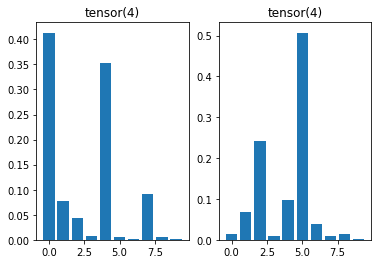

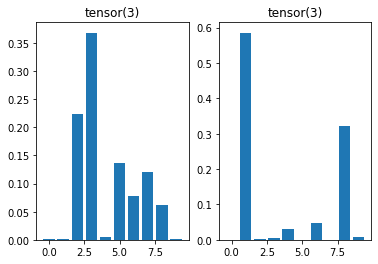

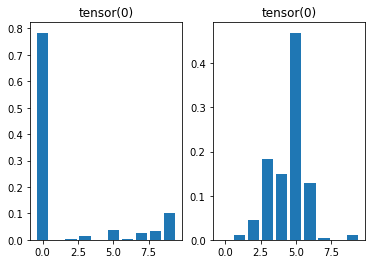

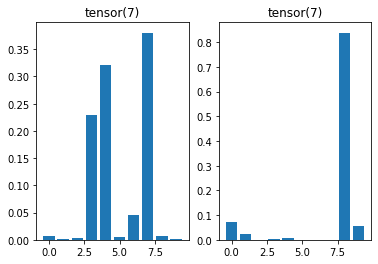

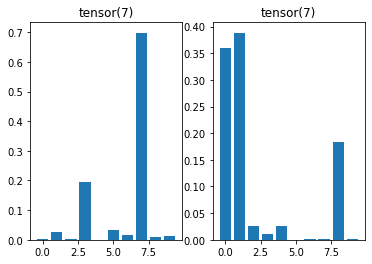

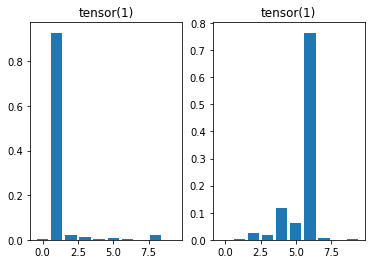

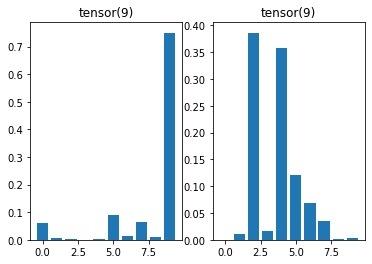

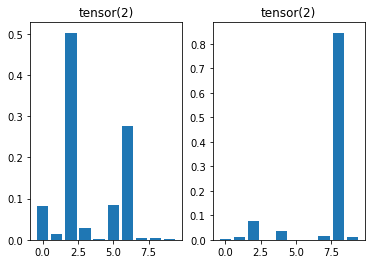

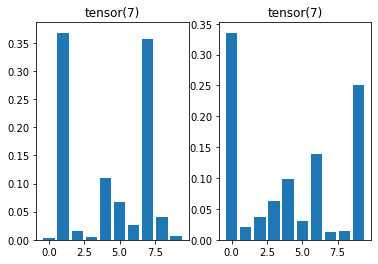

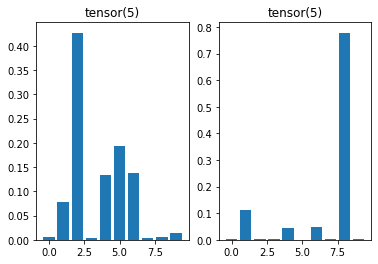

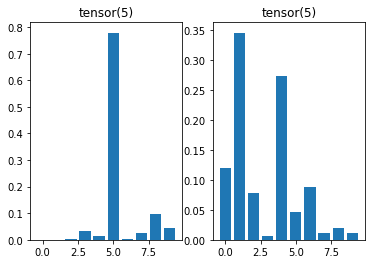

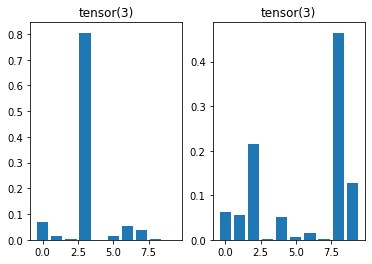

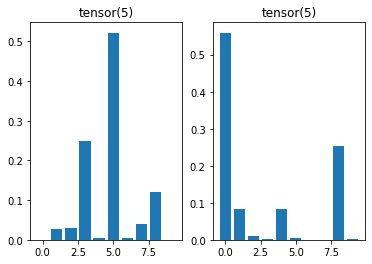

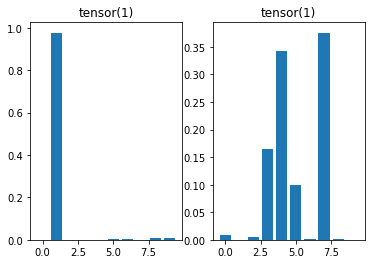

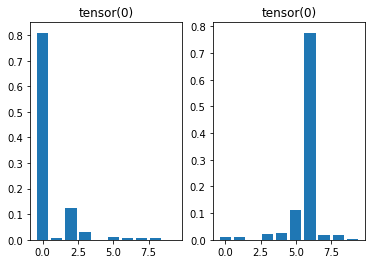

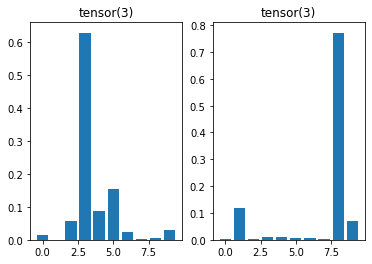

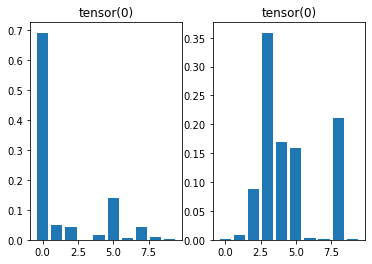

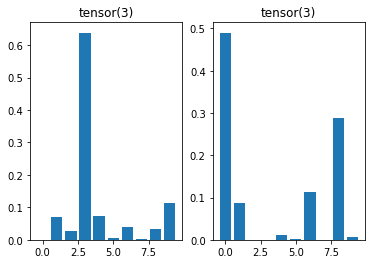

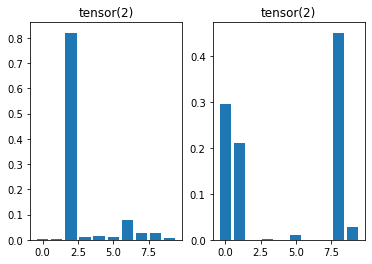

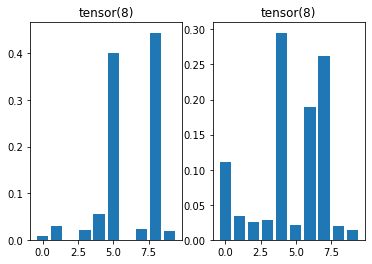

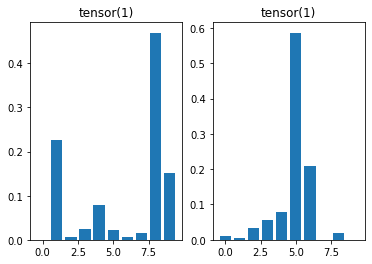

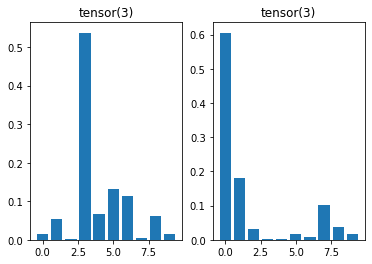

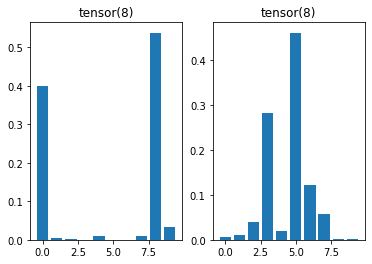

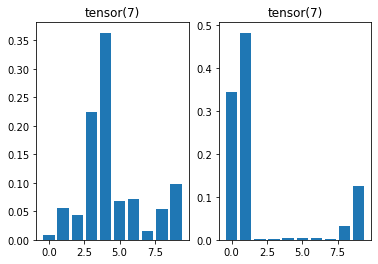

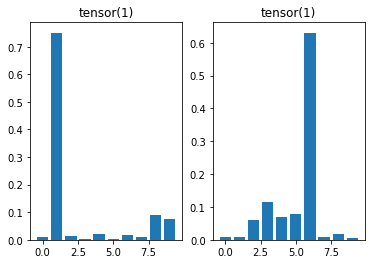

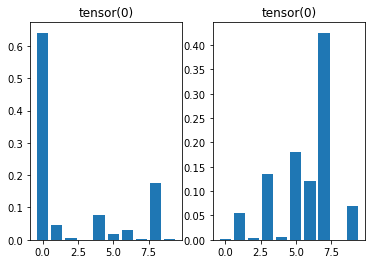

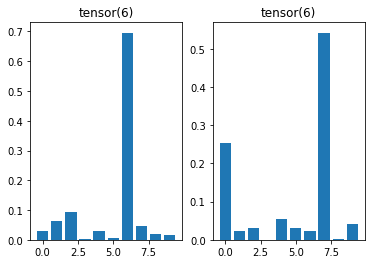

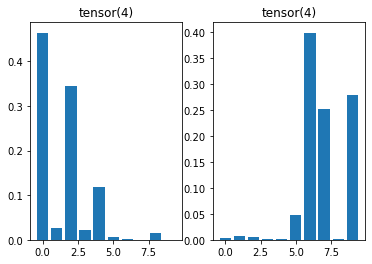

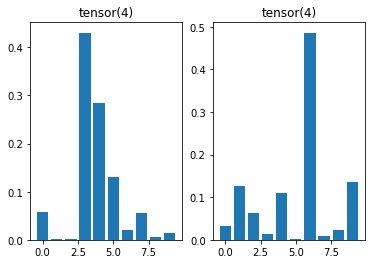

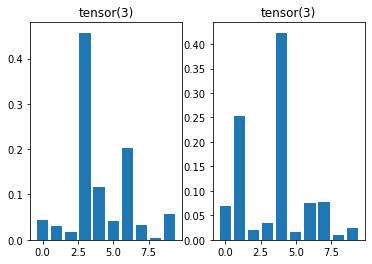

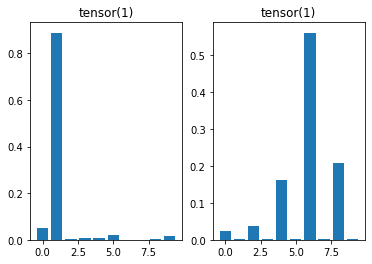

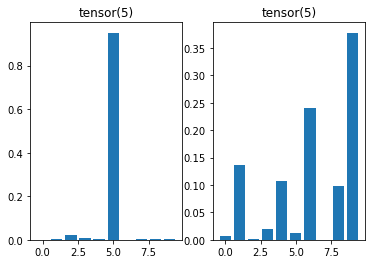

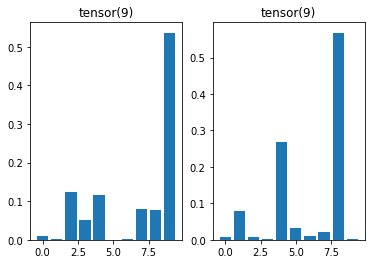

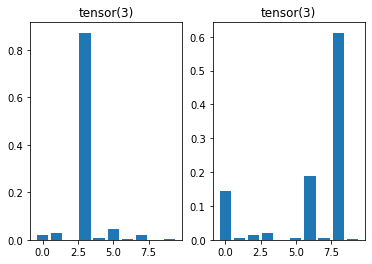

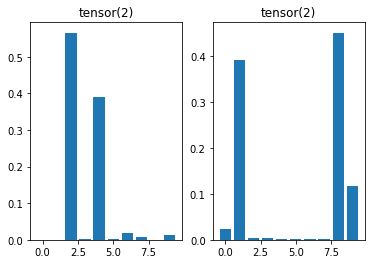

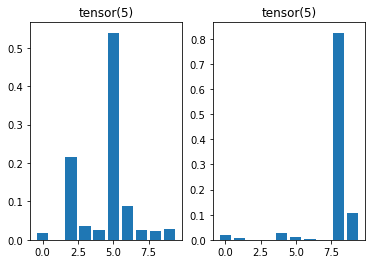

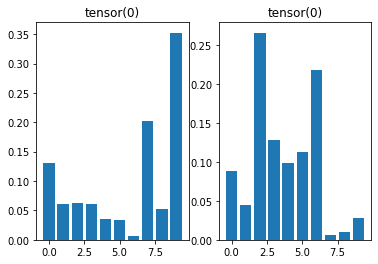

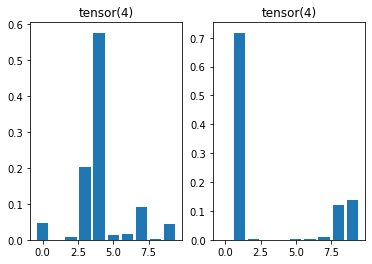

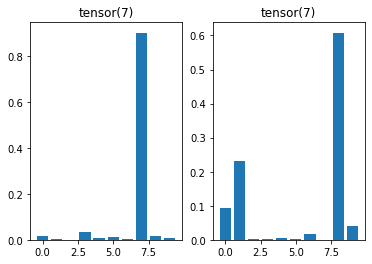

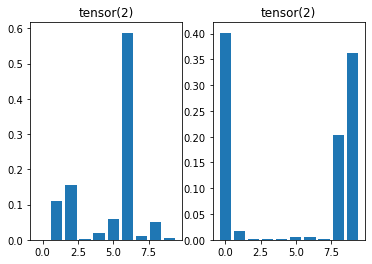

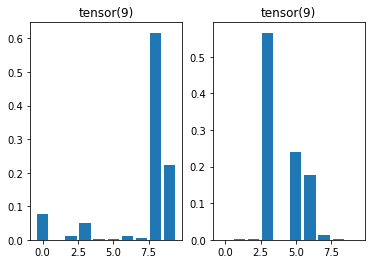

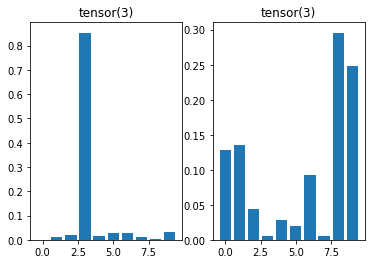

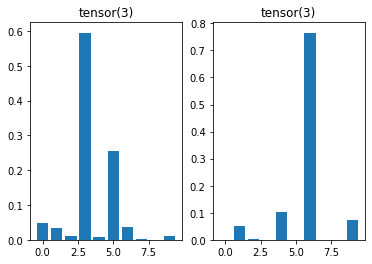

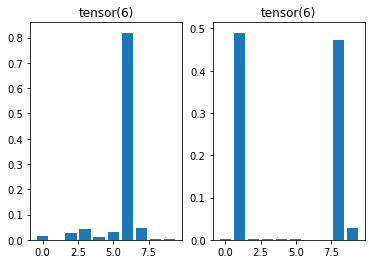

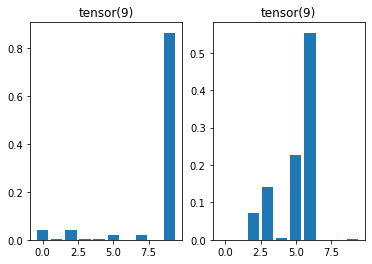

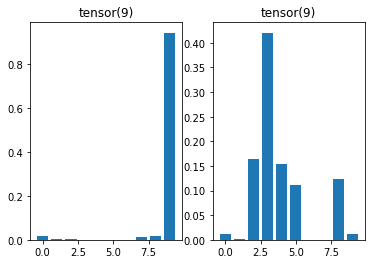

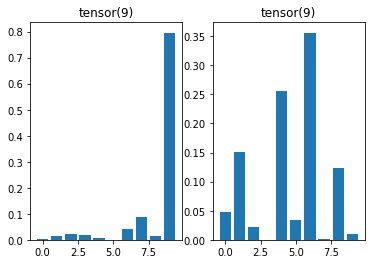

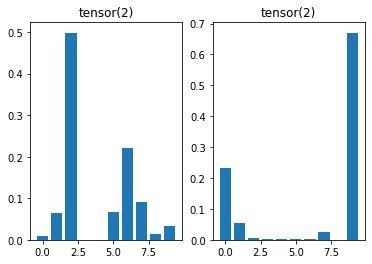

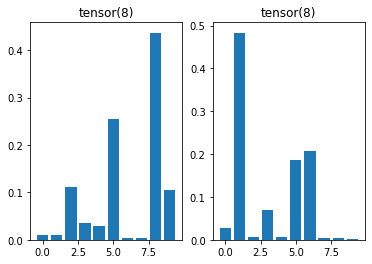

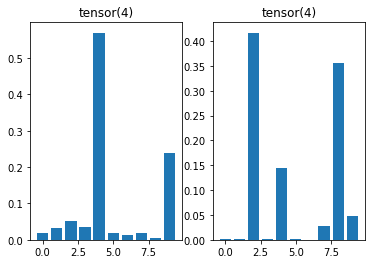

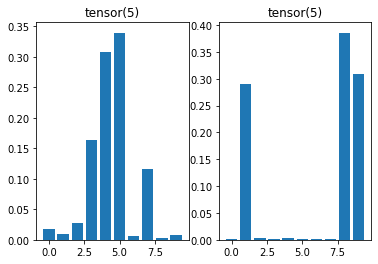

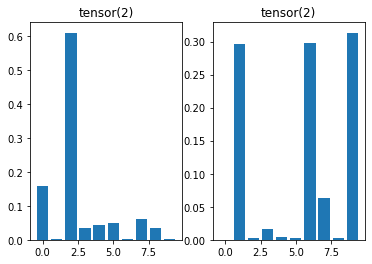

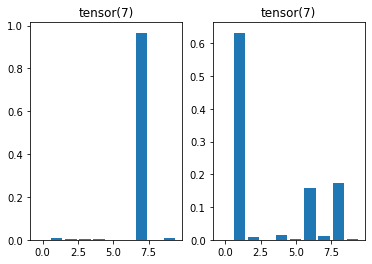

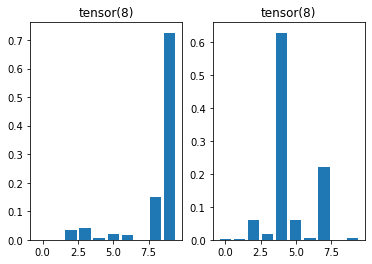

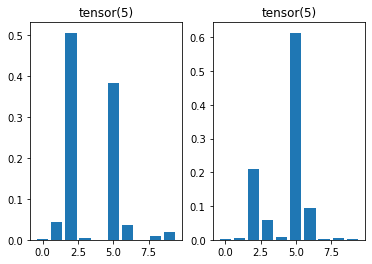

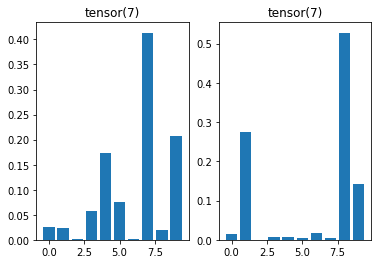

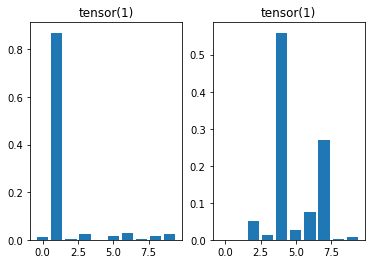

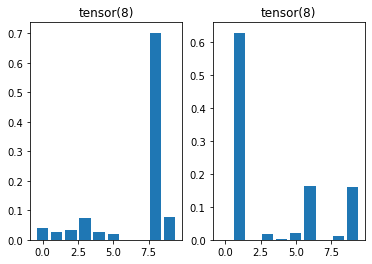

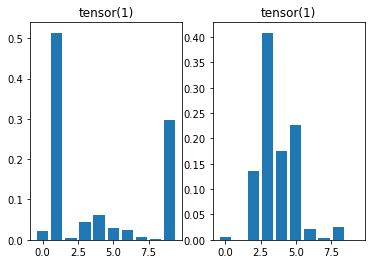

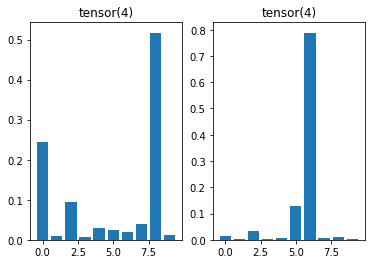

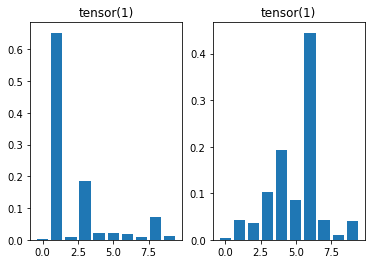

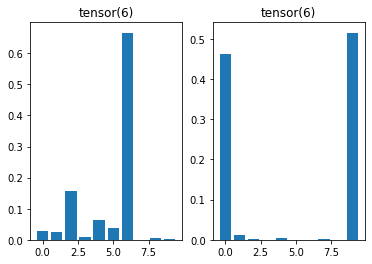

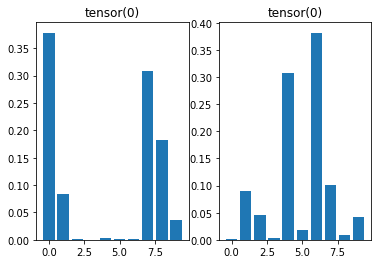

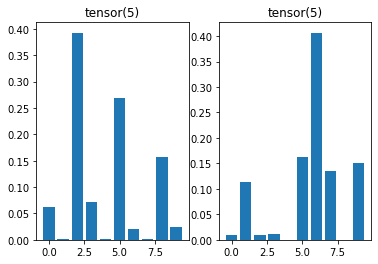

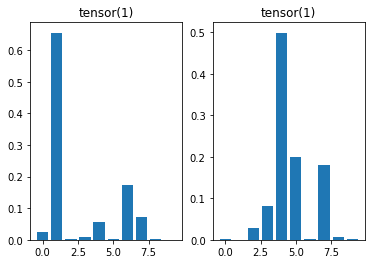

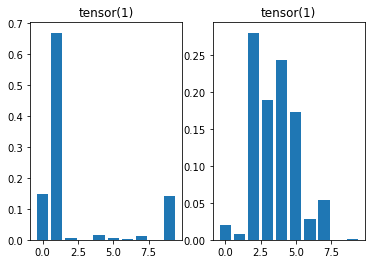

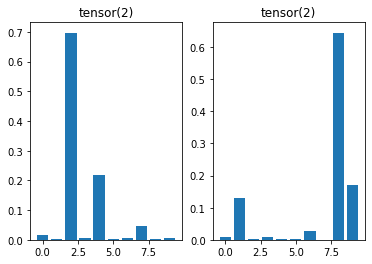

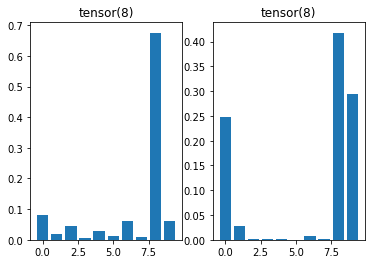

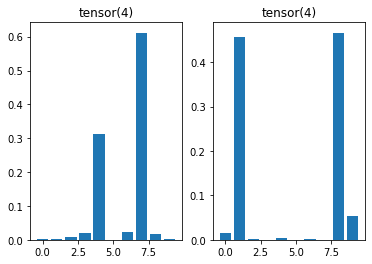

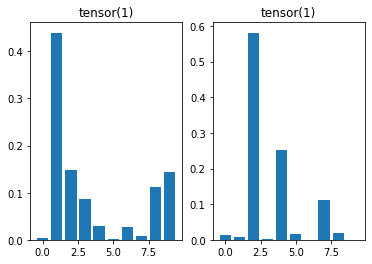

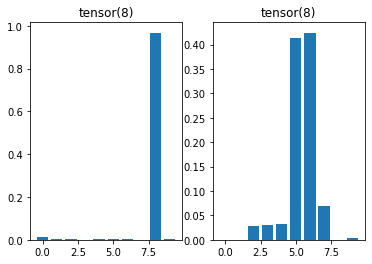

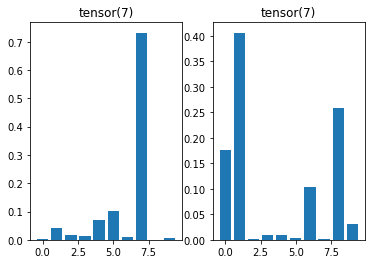

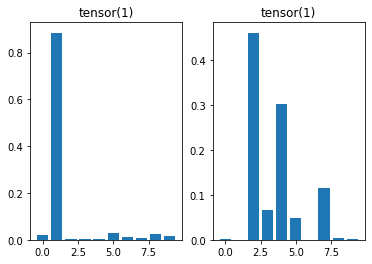

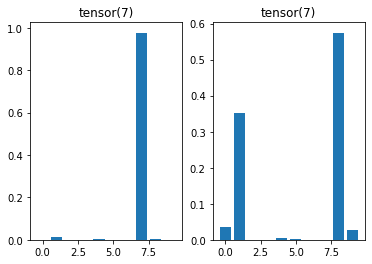

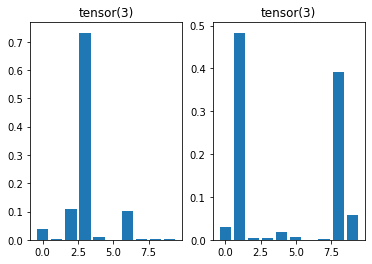

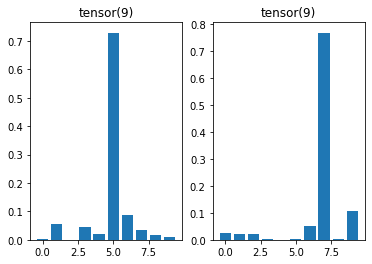

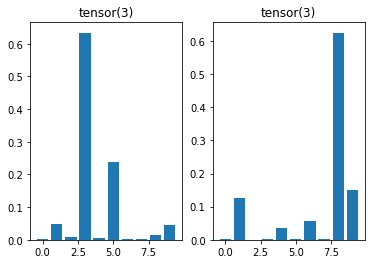

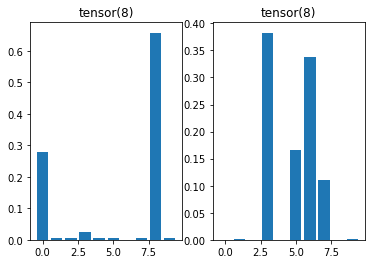

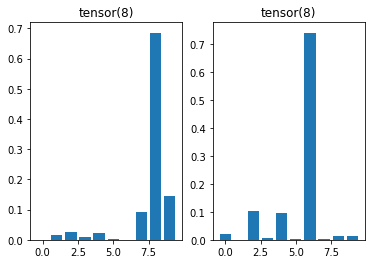

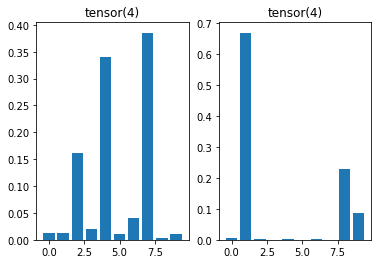

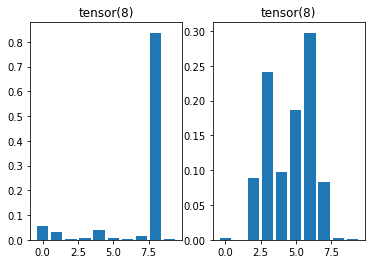

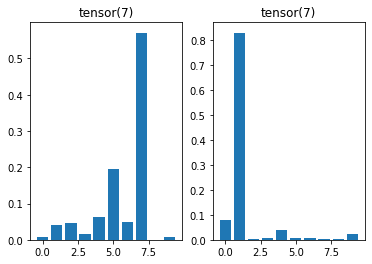

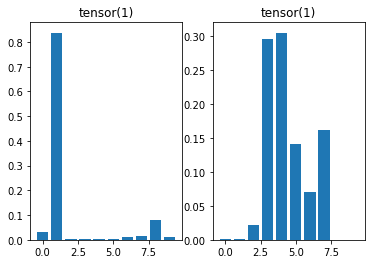

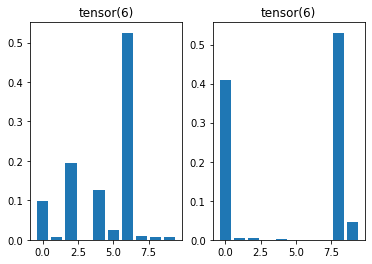

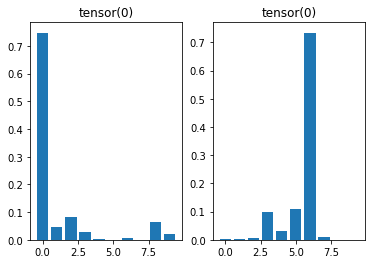

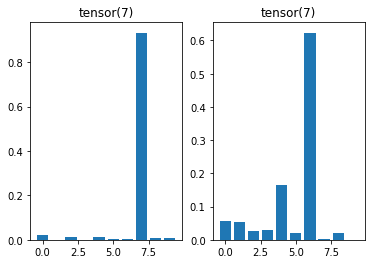

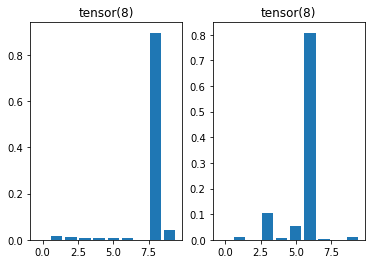

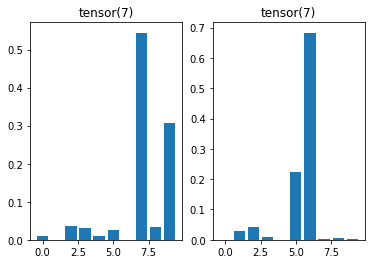

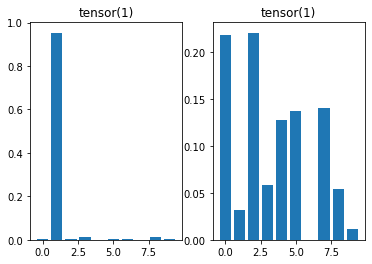

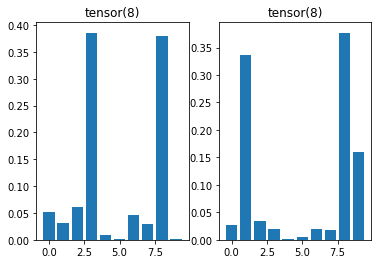

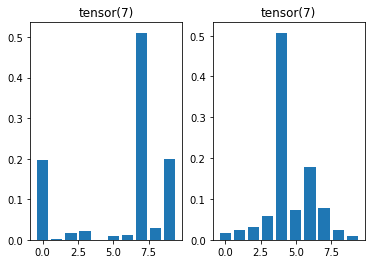

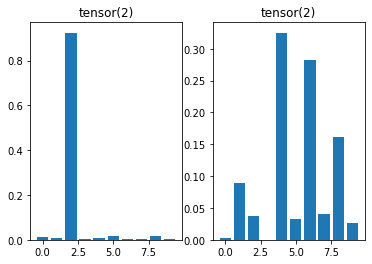

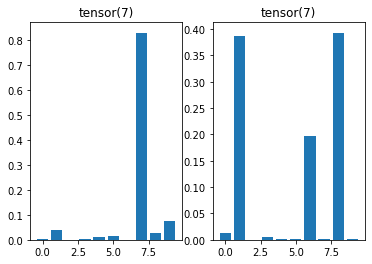

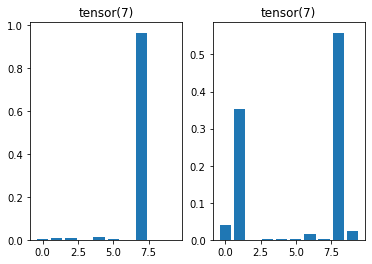

In [15]:
plot_individual_prediction(bb[0], bb[1], device, net, net_fake) 

## histograms for combNet

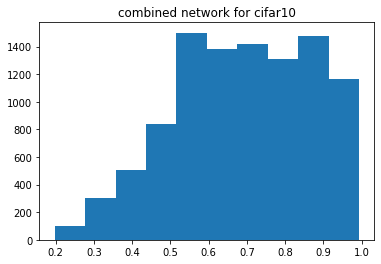

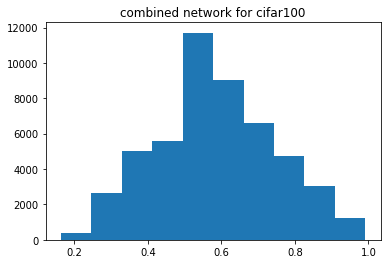

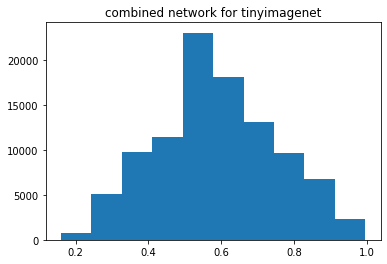

In [11]:
from utils import maxclass_hist, prediction_hist
maxclass_hist(testloader, comb_net, device, plt_title="combined network for cifar10")
maxclass_hist(stealloader, comb_net, device, plt_title="combined network for cifar100")
maxclass_hist(outlier_loader, comb_net, device, plt_title="combined network for tinyimagenet")

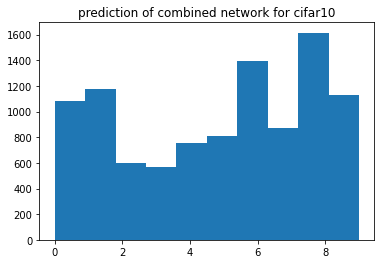

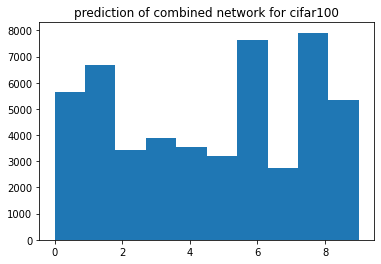

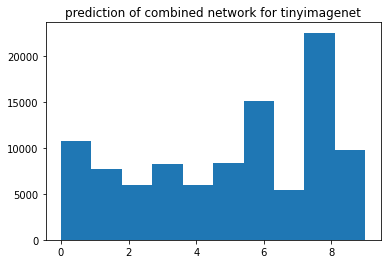

In [12]:
prediction_hist(testloader, comb_net, device, plt_title="prediction of combined network for cifar10")
prediction_hist(stealloader, comb_net, device, plt_title="prediction of combined network for cifar100")
prediction_hist(outlier_loader, comb_net, device, plt_title="prediction of combined network for tinyimagenet")

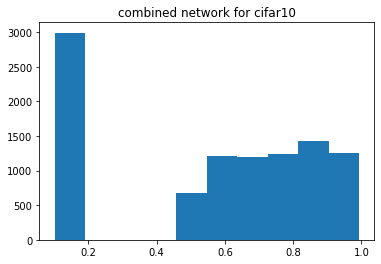

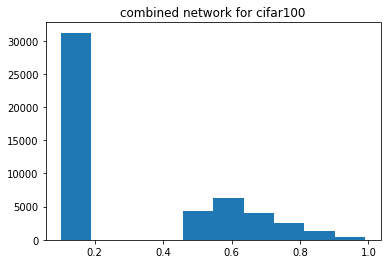

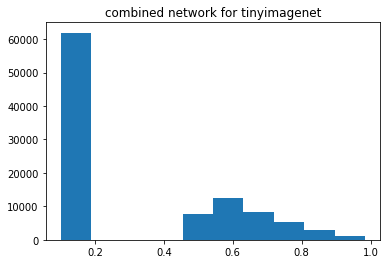

In [11]:
from utils import maxclass_hist, prediction_hist
maxclass_hist(testloader, comb_net, device, plt_title="combined network for cifar10")
maxclass_hist(stealloader, comb_net, device, plt_title="combined network for cifar100")
maxclass_hist(outlier_loader, comb_net, device, plt_title="combined network for tinyimagenet")

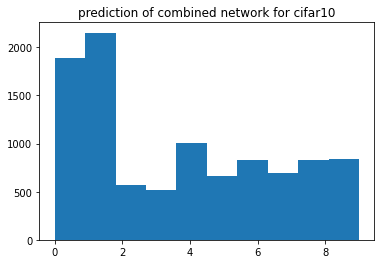

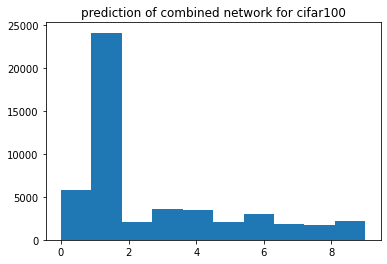

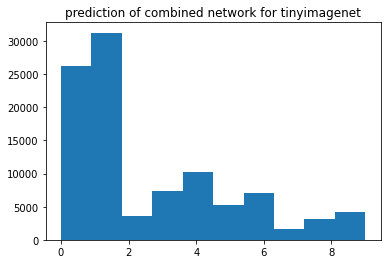

In [12]:
prediction_hist(testloader, comb_net, device, plt_title="prediction of combined network for cifar10")
prediction_hist(stealloader, comb_net, device, plt_title="prediction of combined network for cifar100")
prediction_hist(outlier_loader, comb_net, device, plt_title="prediction of combined network for tinyimagenet")

## train attack network with hard label

In [14]:
from utils import train_stmodel_comb_hard_label, select_data,test_corr_model

In [15]:
att_net = AttackNet()

In [16]:
criterion_att = nn.CrossEntropyLoss()
optimizer_att = optim.SGD(att_net.parameters(), lr=0.001, momentum=0.9)

In [17]:
selected_loader = select_data(stealloader.dataset, args.nb_stolen,
                              trainloader.batch_size, False)

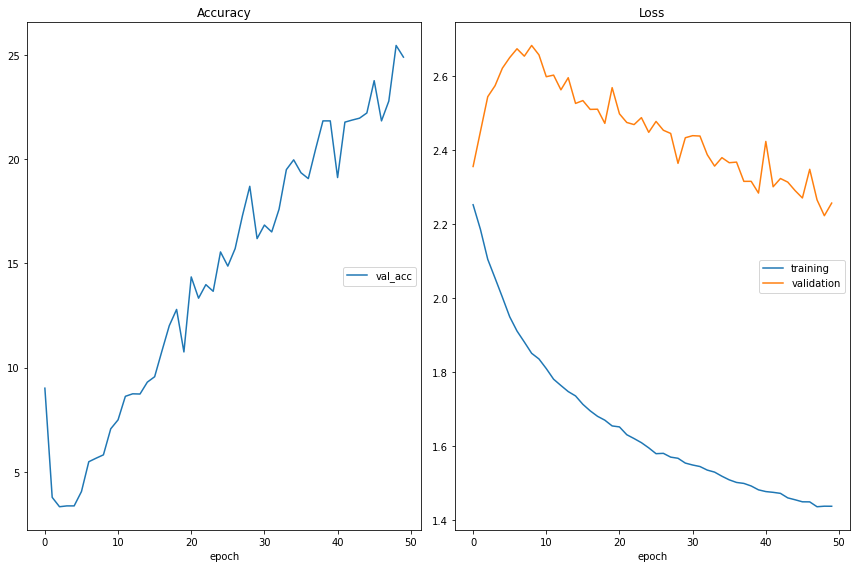

Accuracy
	val_acc          	 (min:    3.320, max:   25.460, cur:   24.900)
Loss
	training         	 (min:    1.435, max:    2.252, cur:    1.437)
	validation       	 (min:    2.222, max:    2.682, cur:    2.256)


In [18]:
att_net, logs_att = train_stmodel_comb_hard_label(selected_loader, att_net, criterion_att, optimizer_att, comb_net, 
                                       epochs=args.att_epochs, device=device, test_loader=testloader, 
                                         save_dir = args.save_dir, 
                                       save_model=args.att_model)

## train attack network for multiple taus

- 그냥 여러 tau 에 대해서 다 돌려놓아 보고 싶을 때 이 부분 활용!

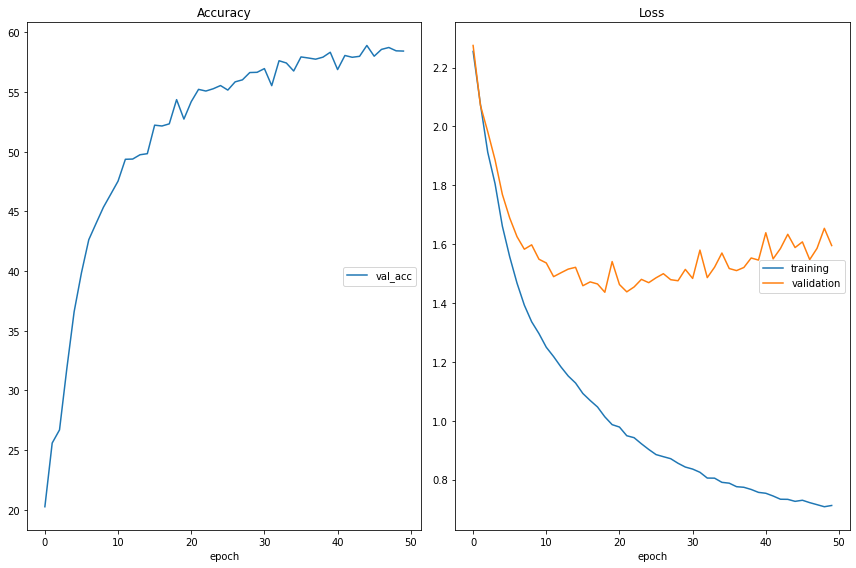

Accuracy
	val_acc          	 (min:   20.250, max:   58.910, cur:   58.440)
Loss
	training         	 (min:    0.708, max:    2.255, cur:    0.712)
	validation       	 (min:    1.437, max:    2.275, cur:    1.595)


NameError: name 'test_corr_model' is not defined

In [13]:
from utils import train_stmodel_comb, select_data,test_corr_model
import numpy as np
print(args)
selected_loader = select_data(stealloader.dataset, args.nb_stolen, trainloader.batch_size, False)

for tau in np.arange(0.1, 1.1, 0.1): 
    comb_net = CombNet(net, net_fake, tau=tau)
    att_net = AttackNet()
    criterion_att = nn.CrossEntropyLoss()
    optimizer_att = optim.SGD(att_net.parameters(), lr=0.001, momentum=0.9)
    print("train for tau",tau)
    _, logs_att = train_stmodel_comb(selected_loader, att_net, criterion_att, optimizer_att, comb_net, 
                                       epochs=args.att_epochs, device=device, test_loader=testloader, 
                                         save_dir = args.save_dir, 
                                       save_model=str(tau)+"_cifar_att_net.pth")
    loss1, loss2, acc1, acc2, corr = test_corr_model(comb_net, att_net, testloader, criterion_att, device)
    del loss1, loss2, acc1, acc2, corr, comb_net, att_net
    torch.cuda.empty_cache()

### load att net

In [15]:
att_net = AttackNet()
att_net.load_state_dict(torch.load(os.path.join(args.save_dir,args.att_model),map_location='cpu'))

<All keys matched successfully>

## test steal model

In [19]:
from utils import test_corr_model
criterion_att = nn.CrossEntropyLoss()
loss1, loss2, acc1, acc2, corr = test_corr_model(comb_net, att_net, testloader, criterion_att, device)

Accuracy/Loss 1: 62.96/1.9312
Accuracy/Loss 2: 24.90/2.2561
Correspondence:  tensor(42.4800)
